In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.utils import resample
from sklearn import preprocessing
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, recall_score, balanced_accuracy_score, roc_auc_score

import matplotlib.pyplot as py
from statistics import stdev

from functools import reduce

import warnings

import pickle

## data cleaning functions

In [3]:
def merge_first_day_final_day(df):
    final_day_column = ['record_id','e11_diagnosis_discharge','e13_notdengue']
    final_day = df[df['redcap_event_name'] == 'discharge_arm_1'][final_day_column] 
    
    required_column = pd.read_excel('Feature.xlsx',sheet_name='required_column')
    first_day = df[df['redcap_event_name'] == 'enrollment_study_d_arm_1']
    first_day = first_day[required_column['column_name']]
    
    return pd.merge(first_day,final_day,on='record_id')


def str_to_date(date):
    date_time_obj = datetime.strptime(date, '%Y-%m-%d')
    return date_time_obj
    
    
def calculate_fever_day(df):
    for index, row in df.iterrows():
        if np.isnan(row['a08a_day_of_fever']):
            try:
                enrollment_date = str(row['a07_datetime_enrol']).split()[0]
                fever_date = str(row['a08_datetime_feveronset']).split()[0]
                date_diff = str_to_date(enrollment_date) - str_to_date(fever_date)
                df.loc[index,'a08a_day_of_fever'] = date_diff.days + 1
            except Exception as e:
                print("could not compute fever day for",row['record_id'],"because",e)
                df.drop(index)
    return df

def calculate_bp(df):
    for index, row in df.iterrows():
        if np.isnan(row['d04_systolicbp']):
            try:
                split_bp = row['d04_bp'].split('/')
                df.loc[index,'d04_systolicbp'] = split_bp[0]
                df.loc[index,'d04_diastolicbp'] = split_bp[1]
            except:
                print('could not compute bp for', row['record_id'])
    return df


def fill_blank(df, pair, replace_no, verbose=0):
    upd = pair[0]
    ref = pair[1]
    df_tmp = pd.DataFrame(df.copy())
    df.loc[df[ref] == replace_no, upd] = 0 
    if verbose == 1:
        print(df_tmp[upd].value_counts()) 
        print(df[upd].value_counts()) 
        del df_tmp
    return df

def remove_cases_with_many_missing_data(df):
    new_df = df.dropna(axis=0, how='any', thresh=round(df.shape[-1]*0.5))
    print('removing cases with >50% missing data ...')
    print(df.shape[0] - new_df.shape[0])
    return new_df

def remove_col_with_many_missing_data(df,thresh):
    ori_df = df
    drop_col = []
    for c in df.columns:
        temp = df[df[c].isna()]
        if temp.shape[0] > round(df.shape[1]*thresh):
            df = df.drop([c],axis=1)
            drop_col.append(c)
    print('removing columns with >'+str(thresh*100)+'% missing data ...')
    print(ori_df.shape, df.shape)
    print(ori_df.shape[1]-df.shape[1],'columns removed')
    print('removed columns:',drop_col)
    return df


def remove_spec_char(df):
    spec_chars = ["mmol/l", "mmol/L", "MMOL/L", "<"]
    for col in ['d37_glucose_admission']:
        for char in spec_chars:
            for index, row in df.iterrows():
                df.loc[index,col] = str(row[col]).replace(char, "")
    return df


def convert_to_float(df):
    for col in df.columns.tolist():
        try:
            df[f'{col}'] = df[f'{col}'].astype('float')
        except:
            print(f'drop column \'{col}\'')
            df.drop([f'{col}'], axis=1, inplace=True)

    if len(df.select_dtypes(float).columns) != df.shape[-1]:
        raise ValueError("there exist non-float type in the dataframe")

    return df

        
def drop_not_confirmed_dengue(df, verbose=0):
    confirmed_dengue = df[df['e13_notdengue'] != 1]
    if verbose == 1:
        print(df['e13_notdengue'].value_counts())
    print("confirmed dengue: ", confirmed_dengue.shape[0])
    return confirmed_dengue


def select_before_fever_day(df,before_day, verbose=0):
    required_cases = df[df['a08a_day_of_fever']>0]
    required_cases = required_cases[required_cases['a08a_day_of_fever']<before_day]
    if verbose == 1:
        print(df['a08a_day_of_fever'].value_counts())
    print("confirmed dengue before Day ", before_day, ": ", required_cases.shape[0])
    return required_cases


def drop_severe_on_admission(df, verbose=0):
    required_cases = df[df['d35_diagnosis_admission']!=3]
    if verbose == 1:
        print(df['d35_diagnosis_admission'].value_counts())
    print("after removing severe on admission:", required_cases.shape[0])
    return required_cases


def print_data_distribution(df):
    result = [len(df[df['e11_diagnosis_discharge']==level]) for level in [1,2,3]]
    for i, r in enumerate(result):
        print("level ",i+1,": ", r)
        
    
def print_col_with_missing_data(df):
    for col in df.columns:
        temp = df[df[col].isna()]
        if temp.shape[0] > 0:
            print(col, temp.shape[0]/df.shape[0])
    
    


## data cleaning main code

In [9]:
# Step 0: read csv file
csv_file = 'FOMD06U16AdultDengue_DATA_2021-10-06_1435.csv'
df = pd.read_csv(csv_file, na_values=["NA",""], keep_default_na=False)

# step 1: data preprocessing
df = merge_first_day_final_day(df)
df = remove_cases_with_many_missing_data(df)
df = calculate_fever_day(df)
df = calculate_bp(df)
df = fill_blank(df, ['b10_pregnant','a05_sex'], replace_no=1, verbose=0)
df = fill_blank(df, ['d19_unusualvaginalbleeding','a05_sex'], replace_no=1, verbose=0)
df = fill_blank(df, ['b12_regularmedication','b11_regularmedication'], replace_no=0, verbose=0)
df = fill_blank(df, ['b14_clinicvisit','b13_illnesstreatment'], replace_no=0, verbose=0)
df = fill_blank(df, ['b14a_no_clinicvisit','b14_clinicvisit'], replace_no=0, verbose=0)
df = fill_blank(df, ['b15_paracetamol','b13_illnesstreatment'], replace_no=0, verbose=0)
df = fill_blank(df, ['b15c_paracetamol_total','b15_paracetamol'], replace_no=0, verbose=0)
df = fill_blank(df, ['b16_ibuprofen_voltaren','b13_illnesstreatment'], replace_no=0, verbose=0)
df = fill_blank(df, ['b16c_ibuprofen_tablet','b16_ibuprofen_voltaren'], replace_no=0, verbose=0)
df = fill_blank(df, ['b17_injection','b13_illnesstreatment'], replace_no=0, verbose=0)
df = fill_blank(df, ['b18_suppository_meds','b13_illnesstreatment'], replace_no=0, verbose=0)
df = fill_blank(df, ['b19_antibiotics','b13_illnesstreatment'], replace_no=0, verbose=0)
df = fill_blank(df, ['yes_urineketone','d38_blood_ketones'], replace_no=0, verbose=0)
df = remove_spec_char(df)
print('ori data:', df.shape[0])
print_data_distribution(df)
df.to_csv("check_missing_data.csv", index=False)

# step 2: drop non confirmed dengue
df = drop_not_confirmed_dengue(df)
print_data_distribution(df)

# step 3: drop severe dengue on admission
df = drop_severe_on_admission(df)
print_data_distribution(df)

# step 4: select before fever day
for day in range(4,9):
    temp_df = select_before_fever_day(df,before_day=day)
    print('before day ', day)
    print_data_distribution(temp_df)
    print('---------------------')

removing cases with >50% missing data ...
1
could not compute bp for 34
ori data: 580
level  1 :  54
level  2 :  415
level  3 :  46
confirmed dengue:  510
level  1 :  52
level  2 :  411
level  3 :  46
after removing severe on admission: 476
level  1 :  52
level  2 :  403
level  3 :  20
confirmed dengue before Day  4 :  95
before day  4
level  1 :  12
level  2 :  78
level  3 :  4
---------------------
confirmed dengue before Day  5 :  264
before day  5
level  1 :  35
level  2 :  216
level  3 :  12
---------------------
confirmed dengue before Day  6 :  374
before day  6
level  1 :  42
level  2 :  314
level  3 :  17
---------------------
confirmed dengue before Day  7 :  438
before day  7
level  1 :  45
level  2 :  372
level  3 :  20
---------------------
confirmed dengue before Day  8 :  463
before day  8
level  1 :  50
level  2 :  392
level  3 :  20
---------------------


In [10]:
#get cleaned data before Day 5
temp_df = select_before_fever_day(df,before_day=5)
temp_df.to_csv("before_day_5__platelet.csv", index=False)

confirmed dengue before Day  5 :  264


## preparation
- combine_into_two_class
- split_train_test
- oversampling
- get_p_value
- get_n_features
- mean
- test_with_different_n_features
- feature_scaling

In [4]:
def combine_into_two_class(df, verbose=0):
    new_level_0 = df[df['e11_diagnosis_discharge']<3]
    new_level_0.loc[:,'e11_diagnosis_discharge'] = 0
    new_level_1 = df[df['e11_diagnosis_discharge']==3]
    new_level_1.loc[:,'e11_diagnosis_discharge'] = 1
    final_df = pd.concat([new_level_0,new_level_1])
    if verbose == 1:
        print(final_df['e11_diagnosis_discharge'].value_counts())
    return final_df


def split_train_test(df, r, verbose=0):
    skf = StratifiedKFold(n_splits=2, random_state=r, shuffle=True)
    X = df.drop(['e11_diagnosis_discharge'], axis=1)
    y = df['e11_diagnosis_discharge']
    split_index_pair = skf.split(X, y)
    train_index_array, test_index_array = split_index_pair
    train_index = train_index_array[0]
    test_index = test_index_array[0]
    train, test = df.iloc[train_index,:], df.iloc[test_index,:]
    if verbose == 1:
        print(X.shape)
        print(y.shape)
        print(split_index_pair)
        print(train_index, test_index)
    return train, test


def replace_missing(df_train, df_test):
    categorical_col = pd.read_excel('Feature.xlsx',sheet_name='categorical')
    numerical_col = pd.read_excel('Feature.xlsx',sheet_name='numerical')
    replace_values = {}
    new_train = df_train
    new_test = df_test
    for feature in df.columns:
        if feature in categorical_col['column_name'].tolist() or feature in numerical_col['column_name'].tolist():
            replace_value = compute_replace_value(df_train,feature)
            new_train = replace_missing_value(new_train, feature, replace_value)
            new_test = replace_missing_value(new_test, feature, replace_value)
            replace_values[feature] = replace_value
    return new_train, new_test, replace_values

def compute_replace_value(df,feature):
    categorical_col = pd.read_excel('Feature.xlsx',sheet_name='categorical')
    numerical_col = pd.read_excel('Feature.xlsx',sheet_name='numerical')
    if feature in numerical_col['column_name'].tolist():
        replace_value = df[feature].mean(skipna = True)
    elif feature in categorical_col['column_name'].tolist():
        replace_value = df[feature].mode()
    return float(replace_value)

def replace_missing_value(df, feature, replace_value):
    for index, row in df.iterrows():
        if np.isnan(row[feature]):
            df.loc[index,feature] = replace_value
    return df


def oversampling(clean_data, verbose=0):
    df_majority = clean_data[clean_data['e11_diagnosis_discharge']==0]
    df_minority_class = clean_data[clean_data['e11_diagnosis_discharge']==1]
    n = df_majority.shape[0] 
    df_minority_oversampled_class = resample(df_minority_class, replace=True, n_samples=n, random_state=0)
    df_oversampled = pd.concat([df_majority, df_minority_oversampled_class])
    if verbose == 1:
        print(clean_data['e11_diagnosis_discharge'].value_counts())
        print(df_oversampled['e11_diagnosis_discharge'].value_counts())
    return df_oversampled


def get_p_value(df, verbose=0):

    new_level_0 = df[df['e11_diagnosis_discharge']==0]
    new_level_1 = df[df['e11_diagnosis_discharge']==1]

    categorical_col = pd.read_excel('Feature.xlsx',sheet_name='categorical')
    numerical_col = pd.read_excel('Feature.xlsx',sheet_name='numerical')

    feature = []
    p_list = []

    for c in df.columns:
        if c not in ['e11_diagnosis_discharge', 'record_id']:

            if c in categorical_col['column_name'].tolist():
                crosstab = pd.crosstab(index=df[c], columns=df['e11_diagnosis_discharge'])
                try:
                    data = [crosstab[i].values.tolist() for i in [0,1]]
                except:
                    if verbose == 1:
                        print(c, " has too many missing data")

                stat, p, dof, expected = chi2_contingency(data)
                feature.append(c)
                p_list.append(p)

            if c in numerical_col['column_name'].tolist():
                level_0 = new_level_0.dropna(subset=[c])
                level_1 = new_level_1.dropna(subset=[c])
                try:
                    stat, p = ttest_ind(level_0[c], level_1[c], equal_var=False)
                    if pd.isna(p):
                        if verbose == 1:
                            print(c, level_0[c].shape, level_1[c].shape)
                            print(new_level_0.shape, new_level_1.shape)
                    else:
                        feature.append(c)
                        p_list.append(p)
                except: 
                    if verbose == 1:
                        print("error occurs while computing p-value using t-test for", c)
                        print(level_0[c].value_counts())
                        print(level_1[c].value_counts())

    feature_p = sorted(zip(p_list,feature))
    p_value = [f for (p,f) in feature_p]

    if verbose == 1:
        for (p,f) in feature_p:
            print("%.6f %s" % (p,f))
    
    return p_value


def get_n_feature(sorted_feature, df_train, df_test, n):
    features = sorted_feature[:n] + ['e11_diagnosis_discharge']
    new_train = df_train[features].dropna()
    new_test = df_test[features].dropna()
    return new_train, new_test


def test_with_different_n_features(ml, sorted_features, train, test, n_features, min_n_sample, verbose=0, tune_param=False):
    n_sample = []
    accuracy = []
    models = []
    
    for n in range(1,n_features):

        new_train, new_test = get_n_feature(sorted_features, train, test, n)
        
        if new_train.shape[0] < min_n_sample:
            break
            
        if new_train[new_train['e11_diagnosis_discharge']==1].shape[0] < 1 or \
        new_test[new_test['e11_diagnosis_discharge']==1].shape[0] < 1:
            break
            
        n_sample.append(new_train.shape[0])
        
        if tune_param:
            print("tuning hyperparameter for n = %d" % n)
        balanced_accuracy, model = ml(new_train, new_test, tune_param=tune_param)
            
        models.append(model)
        accuracy.append(balanced_accuracy)
        
        if verbose == 1:
            print("number of features:", n)
            print("features:", new_train.columns)
            print("number of samples:", new_train.shape[0])
            print("balanced accuracy: %.4f" % (balanced_accuracy),"\n")
        
    return accuracy, n_sample, models


def test_and_tune_with_specific_model(ml, sorted_features, train, test, best_n_feature, verbose=0):

    new_train, new_test = get_n_feature(sorted_features, train, test, best_n_feature)
    
    n_sample = new_train.shape[0]
        
    balanced_accuracy, model = ml(new_train, new_test, tune_param=True)
        
    if verbose == 1:
        print("number of features:", best_n_feature)
        print("features:", new_train.columns)
        print("number of samples:", new_train.shape[0])
        print("balanced accuracy: %.4f" % (balanced_accuracy),"\n")
        
    return accuracy, n_sample, model


#scale feature to range [0,1]
def feature_scaling(x):
    col_name = x.columns
    min_max_scaler = preprocessing.MinMaxScaler()
    x[col_name] = min_max_scaler.fit_transform(x)
    return x[col_name]

## machine learning training
- logistic_regression (with oversampling)
- random_forest (with oversampling)
- one_class_svm

In [5]:
def logistic_regression(new_train, new_test, verbose=0, tune_param=False):
    new_train = oversampling(new_train)
    train_x = new_train.drop(['e11_diagnosis_discharge'], axis=1)
    train_y = new_train['e11_diagnosis_discharge']
    test_x = new_test.drop(['e11_diagnosis_discharge'], axis=1)
    test_y = new_test['e11_diagnosis_discharge']

    if tune_param:
        trained_model = tune_hyperparameter('logistic_regression',train_x,train_y)
    else:
        model = LogisticRegression(solver='liblinear', C=1, multi_class='auto')
        trained_model = model.fit(train_x, train_y)

    y1_pred = trained_model.predict(test_x)

    accuracy_score = balanced_accuracy_score(test_y, y1_pred)
    if verbose == 1:
        print(accuracy_score)
        print(confusion_matrix(test_y, y1_pred))

    return accuracy_score, trained_model


def random_forest(new_train, new_test, verbose=0, tune_param=False):
    new_train = oversampling(new_train, verbose=0)
    train_x = new_train.drop(['e11_diagnosis_discharge'], axis=1)
    train_y = new_train['e11_diagnosis_discharge']
    test_x = new_test.drop(['e11_diagnosis_discharge'], axis=1)
    test_y = new_test['e11_diagnosis_discharge']

    if tune_param:
        trained_model = tune_hyperparameter('random_forest',train_x,train_y)
    else:
        model = RandomForestClassifier(n_estimators=100)
        trained_model = model.fit(train_x, train_y)

    y1_pred = trained_model.predict(test_x)

    accuracy_score = balanced_accuracy_score(test_y, y1_pred)
    if verbose == 1:
        print(accuracy_score)
        print(confusion_matrix(test_y, y1_pred))

    return accuracy_score, trained_model


def one_class_svm(new_train, new_test, verbose=0, tune_param=False):

    if tune_param:
        train_x = new_train.drop(['e11_diagnosis_discharge'], axis=1)
        train_y = new_train['e11_diagnosis_discharge']
        test_x = new_test.drop(['e11_diagnosis_discharge'], axis=1)
        test_y = new_test['e11_diagnosis_discharge']
        trained_model = tune_hyperparameter('one_class_svm',train_x,train_y)
    else:
        train_level_0 = new_train[new_train['e11_diagnosis_discharge']==0]
        train_x = train_level_0.drop(['e11_diagnosis_discharge'], axis=1)
        train_y = train_level_0['e11_diagnosis_discharge']
        test_x = new_test.drop(['e11_diagnosis_discharge'], axis=1)
        test_y = new_test['e11_diagnosis_discharge']
        model = svm.OneClassSVM(kernel='linear', gamma=0.1, nu=0.1)
        trained_model = model.fit(train_x)

    oneclass = trained_model
    fraud_pred = oneclass.predict(test_x).tolist()

    new_fraud_pred = []
    for f in fraud_pred:
        if f == 1:
            new_fraud_pred.append(0)
        else:
            new_fraud_pred.append(1)

    accuracy_score = balanced_accuracy_score(test_y, new_fraud_pred)
    if verbose == 1:
        print(train_x.shape)
        print(accuracy_score)
        print(confusion_matrix(test_y, new_fraud_pred))

    return accuracy_score, oneclass


def tune_hyperparameter(ml,train_x, train_y, verbose=0):
    if ml == 'logistic_regression':
        model = LogisticRegression()
        param = {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        }
        clf = GridSearchCV(model, param, verbose=1)
        best_model = clf.fit(train_x, train_y)
            
    elif ml == 'random_forest':
        model = RandomForestClassifier()
        param = {
#             'n_estimators': [10, 100, 500],
            'n_estimators': [100],
            'max_depth': [None, 10, 20, 30, 40, 50, 60],
#             'max_features': ['auto', 'sqrt', 'log2'],
            'max_features': ['auto'],
#             'class_weight': [None, 'balanced', 'balanced_subsample'],
            'class_weight': [None],
            'max_leaf_nodes': [None, 10, 20, 30, 40, 50 ,60],
#             'min_impurity_decrease': [0, 0.2, 0.4, 0.6, 0.8]
            'min_impurity_decrease': [0]

        }
        clf = GridSearchCV(model, param, verbose=1)
        best_model = clf.fit(train_x, train_y)
        
    elif ml == 'one_class_svm':
        model = svm.OneClassSVM()
        param = {
#             'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'kernel': ['linear'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10, 100],
            'nu': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        }
        clf = GridSearchCV(model, param, scoring='recall_macro', cv=3, verbose=3)
        new_train_y = []
        for y in train_y.tolist():
            if y==0:
                new_train_y.append(1)
            elif y==1:
                new_train_y.append(-1)
        best_model = clf.fit(train_x, new_train_y)
        
    if verbose == 1:
        print(best_model)
    
    return best_model.best_estimator_

## evaluation - plot graph
- plot_accuracy_feature_graph
- plot_sample_feature_graph
- plot_all_accuracy_feature_graph
- plot_all_sample_feature_graph
- mean
- get_highest_accuracy
- plot_with_without_tuning_accuracy

In [6]:
def plot_accuracy_feature_graph(accuracy):
    py.plot(range(1,len(accuracy)+1),accuracy)  
    py.xlabel('number of features')
    py.ylabel('accuracy')
    py.show()
    
    
def plot_sample_feature_graph(n_samples):
    py.plot(range(1,len(n_samples)+1),n_samples)  
    py.xlabel('number of features')
    py.ylabel('number of samples')
    py.show()
    
    
def plot_all_accuracy_feature_graph(all_accuracy):
    for accuracy in all_accuracy:
        py.plot(range(1,len(accuracy)+1),accuracy)  
    py.xlabel('number of features')
    py.ylabel('accuracy')
    py.legend(range(1,len(all_accuracy)+1))
    py.show()
    
    
def plot_all_sample_feature_graph(all_n_samples):
    for n_samples in all_n_samples:
        py.plot(range(1,len(n_samples)+1),n_samples)  
    py.xlabel('number of features')
    py.ylabel('number of samples')
    py.legend(range(1,len(all_n_samples)+1))
    py.show()
    
def mean(accuracy):
    data = np.array(accuracy)
    return np.mean(data)


def get_highest_accuracy(accuracy, n_samples, models, sorted_features, verbose=0):
    highest_accuracy = max(accuracy)
    highest_accuracy_index = accuracy.index(max(accuracy))
    best_n_features = highest_accuracy_index+1
    n_sample = n_samples[highest_accuracy_index]
    best_model = models[highest_accuracy_index]
    if verbose == 1:
        print("Highest accuracy:",highest_accuracy)
        print("number_of_samples:", n_sample)
        print("n:",best_n_features)
        print("features:",sorted_features[:best_n_features],"\n")
    return highest_accuracy, best_n_features, best_model

    
def plot_with_without_tuning_accuracy(without_tuning_accuracy, with_tuning_accuracy):

    py.plot(range(1,len(without_tuning_accuracy)+1),without_tuning_accuracy)

    py.plot(range(1,len(with_tuning_accuracy)+1),with_tuning_accuracy)

    py.xlabel('number of features')
    py.ylabel('accuracy')
    py.legend(['without tuning','with tuning'])
    py.show()

## main code (use p-value from all train set)

without tuning:
Highest accuracy: 0.6825396825396826
number_of_samples: 130
n: 11
features: ['d38_blood_ketones', 'd26_tenderness', 'c10b_aches', 'c09_chestdiscomfort', 'd12_clinical_shock', 'd13_poor_skin_perfusion', 'd24_pleuraleffusion', 'd27_liverpalpable', 'd28_ascites', 'd32_neurologyabnormal', 'b16c_ibuprofen_tablet'] 

best_model_hyperparameter:  {'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'linear', 'max_iter': -1, 'nu': 0.1, 'shrinking': True, 'tol': 0.001, 'verbose': False} 

tuning hyperparameter for n = 1
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.000 to

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.012 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.250 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.012 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.012 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.250 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.012 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.250 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.012 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.250 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.012 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.250 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.012 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.012 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.250 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.035 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.333 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=auto, ke

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.333 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.291 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.507 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.291 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.507 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.035 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.047 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.333 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.507 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.047 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.333 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.047 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.333 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.047 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.291 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.507 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.375 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.291 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.507 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.047 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.333 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.291 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.507 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.375 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.047 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.333 total time=   0.0s
tuning hyperparameter for n = 7
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END ga

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.047 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.333 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.364 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.047 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.333 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.507 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.364 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.507 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.333 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.507 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.291 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.507 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.047 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.333 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.364 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.333 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.375 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.507 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.047 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.333 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.291 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.375 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.291 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.507 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.333 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.364 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.507 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.386 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.507 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.507 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.375 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.291 total time=   0.0s
[CV 3/3] END ....gamma=1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.200 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.574 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.125 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.544 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.062 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.103 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.515 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.412 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.436 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.200 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.192 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.574 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.125 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.192 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.544 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.062 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.103 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.515 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.412 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.436 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.653 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.212 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.218 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.603 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.200 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.574 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.125 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.544 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.062 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.103 total time=   0.0s
[CV 3/3] END gamma=scale, ke

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.653 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.212 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.218 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.603 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.200 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.192 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.574 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.125 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.192 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.544 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.062 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.269 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.582 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.237 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.653 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.212 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.218 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.603 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.200 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.574 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.375 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.359 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.485 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.312 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.321 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.512 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.269 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.582 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.237 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.653 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.062 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.103 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.515 total time=   0.0s
tuning hyperparameter for n = 15
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.475 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.462 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.397 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.425 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.497 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.375 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.321 total time=   0.0s
[CV 3/3] END g

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.421 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.050 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.179 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.447 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.154 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.115 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.529 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.475 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.462 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.497 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.362 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.321 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.453 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.325 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.269 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.409 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.237 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.231 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.479 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.175 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.529 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.475 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.462 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.397 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.425 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.497 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.362 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.321 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.453 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.325 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.269 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.050 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.179 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.462 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.179 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.141 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.529 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.475 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.462 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.512 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.376 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.050 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.179 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.462 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.179 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.141 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.529 total time=   0.0s
tuning hyperparameter for n = 18
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.475 total time=   0.0s
[CV 2/3] END g

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.218 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.376 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.050 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.179 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.462 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.179 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.141 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.529 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.475 total time=   0.0s
[CV 2/3] END ....gamma=1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.421 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.128 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.362 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.128 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.026 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.038 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.474 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.421 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.128 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.362 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.128 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.026 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.553 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.421 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.128 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.362 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.423 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.482 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.582 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.553 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.423 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.462 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.456 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.423 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.482 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.582 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.553 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.362 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.128 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.026 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.038 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.474 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.423 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.462 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.456 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.421 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.128 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.362 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.128 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.026 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.482 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.582 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.553 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.128 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.026 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.038 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.474 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.423 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.462 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.456 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.423 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.482 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.553 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.421 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.128 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.362 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.128 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.423 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.482 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.582 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.553 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.038 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.474 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.423 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.474 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.456 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.423 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.482 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.582 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.362 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.128 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.026 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.038 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.474 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.423 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.462 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.456 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.423 total time=   0.0s
[CV 3/3] END .gamma=auto, ke

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.421 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.128 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.362 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.051 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.128 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.418 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.026 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.038 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.568 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.553 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.421 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.385 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.423 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.482 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.568 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.553 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.244 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.435 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.544 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.397 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.412 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.487 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.353 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.359 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.338 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.308 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.282 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.128 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.544 total time=   0.0s
tuning hyperparameter for n = 29
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.487 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.449 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.412 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.462 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.353 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 3/3] END g

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.353 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.308 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.308 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.479 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.506 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.218 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.218 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.576 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.192 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.444 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.115 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.444 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.474 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.449 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.412 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.462 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.353 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.372 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.321 total time=   0.0s
[CV 3/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.154 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.474 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.038 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.154 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.444 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.115 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.444 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.474 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.449 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.412 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.462 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.579 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.282 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.476 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.231 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.503 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.154 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.474 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.038 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.154 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.372 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.256 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.579 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.282 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.476 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.231 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.503 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.154 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.474 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.462 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.353 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.372 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.321 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.379 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.372 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.256 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.579 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.282 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.476 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.154 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.444 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.115 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.444 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.487 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.436 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.412 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.462 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.353 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.372 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.503 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.154 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.488 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.038 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.154 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.444 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.115 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.444 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.487 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.379 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.372 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.256 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.579 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.282 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.476 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.231 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.503 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.141 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.154 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.462 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.353 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.372 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.321 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.379 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.372 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.256 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.579 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.282 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.256 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.476 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.013 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.771 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.771 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.756 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.726 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.256 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.485 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.333 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.218 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.571 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.167 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.154 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.771 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.771 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.726 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.668 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.474 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.359 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.256 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.485 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.333 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.115 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.179 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.570 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.524 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.594 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ....gamma=1, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.115 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.179 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.570 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.115 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.179 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.570 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.524 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
tuning hyperparameter for n = 40
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END g

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.524 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.594 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.115 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.179 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.570 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.594 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.115 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.179 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.570 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.524 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.524 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.594 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.524 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.594 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.115 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.115 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.179 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.570 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.570 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.013 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.524 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.594 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
tuning hyperparameter for n = 45
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END g

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.594 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.115 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.179 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.570 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.524 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.594 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.694 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END ....gamma=1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.588 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.346 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.346 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.585 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.231 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.585 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.295 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.205 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.600 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.192 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.103 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.585 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.115 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.448 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.064 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.026 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.448 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.418 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.427 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.436 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.423 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.372 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.600 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.321 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.600 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.103 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.269 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.464 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.090 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.192 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.448 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.388 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.064 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.051 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.128 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.388 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.038 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.064 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.497 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.026 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.013 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.436 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.445 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.026 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.361 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.013 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.530 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.308 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.423 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.600 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.231 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.600 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.530 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.308 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.423 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.600 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.231 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.372 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.600 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.154 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.282 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.600 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.128 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.244 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.189 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.365 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.149 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.270 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.135 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.230 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.338 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.095 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.203 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.309 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.054 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.068 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.206 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.054 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.054 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.255 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.014 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.027 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.225 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.529 total time=   0.0s
tuning hyperparameter for n 

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.054 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.054 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.255 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.014 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.027 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.225 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.529 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.270 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.419 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.225 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.529 total time=   0.0s
tuning hyperparameter for n = 53
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.257 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.419 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.203 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.351 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.149 total time=   0.0s
[CV 2/3] END g

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.257 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.419 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.203 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.351 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.149 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.485 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.122 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.257 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.338 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.363 total time=   0.0s
tuning hyperparameter for n = 54
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.257 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.419 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.203 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.351 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.149 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.485 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.122 total time=   0.0s
[CV 2/3] END g

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.257 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.338 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.068 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.230 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.294 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.054 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.095 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.255 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.027 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.054 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.240 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.027 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.257 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.338 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.068 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.230 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.294 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.054 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.095 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.255 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.027 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.054 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.225 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.027 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.203 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.351 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.149 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.368 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.122 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.257 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.338 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.068 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.230 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.294 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.375 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.114 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.200 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.328 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.071 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.276 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.029 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.057 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.245 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.057 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.245 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.365 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.314 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.414 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.243 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.365 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.029 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.243 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.314 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.029 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.243 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.314 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.229 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.029 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.243 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.314 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.229 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.229 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.214 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.344 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.200 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.281 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.071 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.260 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.229 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.214 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.344 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.200 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.281 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.071 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.314 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.229 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.214 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.344 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.200 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.281 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.214 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.344 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.200 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.281 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.071 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.260 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.029 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.071 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.243 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.314 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.229 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.214 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.344 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.071 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.260 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.029 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.071 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.411 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.365 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.029 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.314 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.229 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.214 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.344 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.200 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.281 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.071 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.411 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.365 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.029 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
tuning hyperparameter for n = 63
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END g

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.071 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.260 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.029 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.071 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.411 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.365 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.029 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.260 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.029 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.071 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.411 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.365 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.029 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
tuning hyperparameter for n = 64
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END g

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.200 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.281 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.071 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.260 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.029 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.071 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.411 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.365 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.469 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.214 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.344 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.200 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.281 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.071 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.260 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.029 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.071 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.365 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.029 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.365 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.243 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.314 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.366 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.229 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.329 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.214 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.274 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.100 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.263 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.043 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.086 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.414 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.366 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.229 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.329 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.229 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.290 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.229 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.329 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.229 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.290 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.214 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.274 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.229 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.290 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.214 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.274 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.100 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.263 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.043 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.214 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.274 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.100 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.263 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.043 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.086 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.414 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.366 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.100 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.263 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.043 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.086 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.414 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.366 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.366 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.214 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.274 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.100 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.263 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.043 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.086 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.414 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.366 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.290 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.214 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.274 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.100 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.263 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.043 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.086 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.414 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.029 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.329 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.229 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.290 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.214 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.274 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.366 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.366 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.229 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.329 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END ....gamma=1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.229 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.329 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.229 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.290 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.229 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.329 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.229 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.290 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END ....gamma=1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.014 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.366 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.357 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.371 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.229 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.329 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.186 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.243 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.403 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.186 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.229 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.290 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.129 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.214 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.274 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.086 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.100 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.263 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.043 total time=   0.0s
[CV 2/3] END ....gamma=1, ke

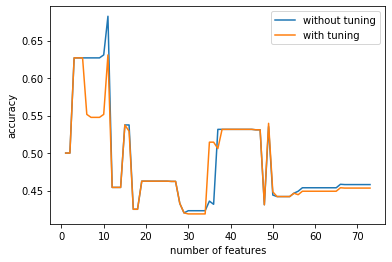

Wall time: 1min 44s


In [11]:
%%time
warnings.filterwarnings('ignore')

csv_file = 'before_day_5.csv'
df = pd.read_csv(csv_file)
df = combine_into_two_class(df)
train, test = split_train_test(df, r=0)

final_sorted_features = get_p_value(train, verbose=0)
n_features = len(final_sorted_features)

ml=one_class_svm

#without tuning
without_tuning_accuracy, without_tuning_n_samples, without_tuning_models = test_with_different_n_features\
                                      (ml, final_sorted_features, train, test, n_features, min_n_sample=50, tune_param=False)
print("without tuning:")
highest_accuracy, best_n_features, without_tuning_best_model = get_highest_accuracy(without_tuning_accuracy, without_tuning_n_samples, without_tuning_models, final_sorted_features, verbose=1)
print("best_model_hyperparameter: ",without_tuning_best_model.get_params(),"\n")

#with tuning
with_tuning_accuracy, with_tuning_n_samples, with_tuning_models = test_with_different_n_features\
                                      (ml, final_sorted_features, train, test, n_features, min_n_sample=50, tune_param=True)
print("with tuning:")
highest_accuracy, best_n_features, with_tuning_best_model = get_highest_accuracy\
                        (with_tuning_accuracy, with_tuning_n_samples, with_tuning_models, final_sorted_features, verbose=1)
print("best_model_hyperparameter: ",with_tuning_best_model.get_params())


#plot with_without_accuracy_graph
plot_with_without_tuning_accuracy(without_tuning_accuracy, with_tuning_accuracy)

#pickle output
output = {
    'final_sorted_features': final_sorted_features,
    'without_tuning': {
        'accuracy': without_tuning_accuracy,
        'n_samples': without_tuning_n_samples,
        'models': without_tuning_models,
        'best_model': without_tuning_best_model
    },
    'with_tuning': {
        'accuracy': with_tuning_accuracy,
        'n_samples': with_tuning_n_samples,
        'models': with_tuning_models,
        'best_model': with_tuning_best_model
    }            
}

# for f in final_sorted_features:
#     print(f)

file_name = 'remove_missing__all_training_set_p_value__before_day_5_all_n.pkl'
with open(file_name, 'wb') as myfile:
    pickle.dump(output,myfile)



# for r in [0,121212,343434,565656,787878]:

#     print(r)
#     temp_train, temp_test = split_train_test(train, r)
#     sorted_features = get_p_value(temp_train, verbose=0)
#     for f in sorted_features:
#         print(f)

## main code (use p-value from all train set) (replace missing data)

without tuning:
Highest accuracy: 0.611111111111111
number_of_samples: 131
n: 3
features: ['d38_blood_ketones', 'd26_tenderness', 'j04_lowestplatelet'] 

best_model_hyperparameter:  {'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'linear', 'max_iter': -1, 'nu': 0.1, 'shrinking': True, 'tol': 0.001, 'verbose': False} 

tuning hyperparameter for n = 1
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.000 total time=   0

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.500 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.500 total time=   0.0s
tuning hyperparameter for n = 2
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.419 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.011 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.250 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.000 total time=   0.0s
[CV 2/3] END ga

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.011 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.250 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.011 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.250 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.419 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.011 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.250 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.011 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.250 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.000 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.011 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.250 total time=   0.0s
tuning hyperparameter for n = 3
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.890 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.432 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END ga

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.687 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.836 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.341 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.727 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.836 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.727 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=scale, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.443 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.836 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.341 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.727 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
tuning hyperparameter for n = 6
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.890 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.443 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 3/3] END ga

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.890 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=scale, ke

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.727 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.341 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.727 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.443 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.420 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.836 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.341 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.727 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.890 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.443 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.836 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.890 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.443 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.727 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.890 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.443 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.295 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
tuning hyperparameter for n = 12
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 3/3] END g

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.330 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.700 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.660 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.622 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.782 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.295 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.261 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.716 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.227 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.635 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.409 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.890 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.261 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.876 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.352 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.782 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.261 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.716 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.227 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.635 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.608 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.034 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.295 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.261 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.716 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.227 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.635 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.608 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.250 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.876 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.352 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.795 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.295 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.250 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.409 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.903 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.409 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.250 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.876 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.352 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.227 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.635 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.608 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.034 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=1.000 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.409 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.903 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.250 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.703 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.227 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.635 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.080 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.608 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.034 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.250 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.876 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.352 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.795 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.295 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.250 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.703 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.903 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.409 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.250 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.876 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.352 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.795 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.295 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.057 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.068 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.489 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.386 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.806 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.432 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.890 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.649 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.057 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.068 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
tuning hyperparameter for n = 19
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.466 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.543 total time=   0.0s
[CV 1/3] END g

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.782 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.250 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.727 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.770 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.703 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.782 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.782 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.250 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.727 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.770 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.613 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.782 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.250 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.782 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.250 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.727 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.466 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.543 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.613 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.782 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.622 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.068 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.466 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.455 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.543 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.613 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.660 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.102 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.552 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.068 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.543 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.227 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.170 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.136 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.727 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.660 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.102 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.552 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.261 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.671 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.227 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.170 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.136 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.727 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.136 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.660 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.068 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.543 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.613 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.685 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.755 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.170 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.136 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.727 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.114 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.700 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.102 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.613 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.398 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.261 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.685 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.755 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.170 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.136 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
tuning hyperparameter for n = 26
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.586 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END g

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.586 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.261 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.700 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.586 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.261 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ....gamma=1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.525 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.586 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.586 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.261 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.700 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.586 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.700 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.525 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.261 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.700 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.525 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.586 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.261 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.700 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END .gamma=auto, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.261 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.700 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.525 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.261 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.148 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.700 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.068 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.525 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.352 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.586 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.725 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.239 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.136 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.741 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.114 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.646 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.114 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.471 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.364 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.261 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.685 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.250 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.755 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.136 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.741 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.471 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.727 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.660 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.471 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.261 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.685 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.261 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.471 total time=   0.0s
tuning hyperparameter for n = 38
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END g

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.727 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.261 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.685 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.239 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=auto, ke

[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.471 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.239 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.727 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.471 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.239 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.727 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END .gamma=0.01, ke

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.261 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.239 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.741 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.727 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.633 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.725 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.741 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.646 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.471 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.516 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.725 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.159 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.782 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.068 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.646 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.471 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.409 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.284 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.352 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.261 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.712 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.782 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.170 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.457 total time=   0.0s
tuning hyperparameter for n = 46
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END g

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END ....gamma=1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.673 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.114 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.673 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.114 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.673 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.114 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=scale, ke

[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ....gamma=1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.673 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.114 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.114 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.443 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.307 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.673 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.114 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.284 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.628 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.698 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.685 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.068 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
tuning hyperparameter for n = 57
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END g

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.295 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.685 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.068 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.673 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.102 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=scale, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.295 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.642 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.685 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ....gamma=1, ke

[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.685 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.068 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.673 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.102 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.565 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END ...gamma=10, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.341 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.295 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.642 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.685 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.755 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.068 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.673 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.114 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.658 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.646 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.125 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.646 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.125 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.552 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.484 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.457 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.409 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.261 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.330 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.227 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.658 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.617 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.606 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.102 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.617 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.148 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.080 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.606 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.102 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.057 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.457 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.457 total time=   0.0s
tuning hyperparameter for n = 64
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.409 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.261 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.330 total time=   0.0s
[CV 3/3] END g

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.409 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.261 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.330 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.227 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.273 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.698 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.216 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.227 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.330 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.655 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.601 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.601 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.606 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

[CV 1/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.601 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.606 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=scale, ke

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.606 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.554 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.473 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ....gamma=1, ke

[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.473 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.682 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.227 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.330 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.655 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.295 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END .gamma=auto, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.601 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.193 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.606 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.473 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.473 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.682 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.473 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.682 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.330 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.655 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.473 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.682 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.330 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.182 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.473 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.682 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.330 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=100, ke

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END .gamma=0.01, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
tuning hyperparameter for n = 77
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END g

[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=0.1, ke

[CV 2/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
tuning hyperparameter for n = 78
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END g

[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=0.1, ke

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.4

[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=0.1, ke

[CV 3/3] END gamma=scale, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=scale, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 2/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=scale, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END .gamma=auto, ke

[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END .gamma=auto, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END ....gamma=1, ke

[CV 1/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 1/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ....gamma=1, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ...gamma=10, ke

[CV 3/3] END .gamma=auto, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END gamma=0.001, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 1/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END gamma=0.001, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ...gamma=10, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END gamma=0.001, ke

[CV 3/3] END ...gamma=10, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END ...gamma=10, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

[CV 2/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.8;, score=0.538 total time=   0.0s
[CV 1/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.080 total time=   0.0s
[CV 2/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.023 total time=   0.0s
[CV 3/3] END gamma=0.001, kernel=linear, nu=0.9;, score=0.541 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 1/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.420 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.432 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.1;, score=0.459 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.318 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ..gamma=100, ke

[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.420 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.2;, score=0.599 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.239 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.341 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.3;, score=0.642 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.216 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.307 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END .gamma=0.01, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END .gamma=0.01, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END .gamma=0.01, ke

[CV 3/3] END ..gamma=100, kernel=linear, nu=0.4;, score=0.615 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.205 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.170 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.5;, score=0.671 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.182 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.125 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.6;, score=0.644 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.159 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.102 total time=   0.0s
[CV 3/3] END ..gamma=100, kernel=linear, nu=0.7;, score=0.592 total time=   0.0s
[CV 1/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.091 total time=   0.0s
[CV 2/3] END ..gamma=100, kernel=linear, nu=0.8;, score=0.045 total time=   0.0s
[CV 3/3] END ..gamma=100, ke

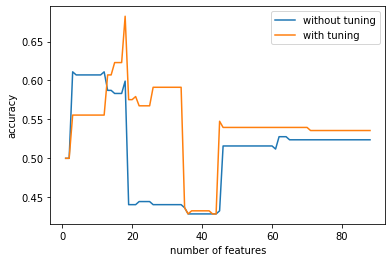

Wall time: 2min 7s


In [21]:
%%time
warnings.filterwarnings('ignore')

csv_file = 'before_day_5.csv'
df = pd.read_csv(csv_file)
df = combine_into_two_class(df)
train, test = split_train_test(df, r=0)
train, test, replace_values = replace_missing(train,test)
final_sorted_features = get_p_value(train, verbose=0)
n_features = len(final_sorted_features)

ml=one_class_svm

#without tuning
without_tuning_accuracy, without_tuning_n_samples, without_tuning_models = test_with_different_n_features\
                                      (ml, final_sorted_features, train, test, n_features, min_n_sample=50, tune_param=False)
print("without tuning:")
highest_accuracy, best_n_features, without_tuning_best_model = get_highest_accuracy(without_tuning_accuracy, without_tuning_n_samples, without_tuning_models, final_sorted_features, verbose=1)
print("best_model_hyperparameter: ",without_tuning_best_model.get_params(),"\n")

#with tuning
with_tuning_accuracy, with_tuning_n_samples, with_tuning_models = test_with_different_n_features\
                                      (ml, final_sorted_features, train, test, n_features, min_n_sample=50, tune_param=True)
print("with tuning:")
highest_accuracy, best_n_features, with_tuning_best_model = get_highest_accuracy(with_tuning_accuracy, with_tuning_n_samples, with_tuning_models, final_sorted_features, verbose=1)
print("best_model_hyperparameter: ",with_tuning_best_model.get_params())


#plot with_without_accuracy_graph
plot_with_without_tuning_accuracy(without_tuning_accuracy, with_tuning_accuracy)

#pickle output
output = {
    'final_sorted_features': final_sorted_features,
    'without_tuning': {
        'accuracy': without_tuning_accuracy,
        'n_samples': without_tuning_n_samples,
        'models': without_tuning_models,
        'best_model': without_tuning_best_model
    },
    'with_tuning': {
        'accuracy': with_tuning_accuracy,
        'n_samples': with_tuning_n_samples,
        'models': with_tuning_models,
        'best_model': with_tuning_best_model
    },           
    'replace_values':replace_values
}

# # for f in final_sorted_features:
# #     print(f)

file_name = 'replace_value__all_training_set_p_value__before_day_5_one_class_svm_all_n.pkl'
with open(file_name, 'wb') as myfile:
    pickle.dump(output,myfile)



# for r in [0,121212,343434,565656,787878]:

#     print(r)
#     temp_train, temp_test = split_train_test(train, r)
#     sorted_features = get_p_value(temp_train, verbose=0)
#     for f in sorted_features:
#         print(f)

deal with missing data
- remove column with more than 25% missing data
- replace with mean (numerical), majority class (categorical)